# Comparing Dropout Rates

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import matplotlib.pyplot as plt

In [3]:
# # # You only need this if you are using a GPU
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
# tf.compat.v1.disable_eager_execution() #needed
tf.__version__

'2.0.0'

In [5]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/81-resnet_d3_dr_0.1.yml'
model_save_dir='/home/garg/data/WeatherBench/predictions/saved_models'
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions'
#start_date='2017-01-01'; end_date='2017-03-31'
start_date='2017-01-01'; end_date='2017-12-31'

In [6]:
    exp_id_path='/home/garg/WeatherBench/nn_configs/B/81-resnet_d3_dr_0.1.yml'
    args=load_args(exp_id_path)
    exp_id=args['exp_id']
    var_dict=args['var_dict']
    batch_size=args['batch_size']
    output_vars=args['output_vars']    
    data_subsample=args['data_subsample']
    norm_subsample=args['norm_subsample']
    nt_in=args['nt_in']
    dt_in=args['dt_in']
    test_years=args['test_years']
    lead_time=args['lead_time'] 

In [7]:
preds_p=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [8]:
#deterministic
#data
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])
mean = xr.open_dataarray(f'{model_save_dir}/{exp_id}_mean.nc') 
std = xr.open_dataarray(f'{model_save_dir}/{exp_id}_std.nc')

if (start_date and end_date)!=None:
    ds_test=ds.sel(time=slice(start_date,end_date))
else:
    ds_test= ds.sel(time=slice(test_years[0],test_years[-1]))  

dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=batch_size, shuffle=False, 
                        load=True,mean=mean, std=std, output_vars=output_vars, nt_in=nt_in, 
                        dt_in=dt_in, data_subsample = data_subsample) 

#model
saved_model_path=f'{model_save_dir}/{exp_id}.h5'
substr=['resnet','unet_google','unet']
assert any(x in exp_id for x in substr)

model=tf.keras.models.load_model(saved_model_path,
                                 custom_objects={'PeriodicConv2D':PeriodicConv2D,'lat_mse': tf.keras.losses.mse})

preds = model.predict(dg_test, verbose=1) #deterministic
preds=preds* dg_test.std.isel(level=dg_test.output_idxs).values+dg_test.mean.isel(level=dg_test.output_idxs).values

DG start 10:09:23.522263
DG normalize 10:09:23.536418
DG load 10:09:23.541752
Loading data into RAM
DG done 10:09:31.447285
136/136 [==============================] - 22s 161ms/step


In [9]:
preds.shape, preds.dtype

((4342, 32, 64, 2), dtype('float64'))

In [10]:
#numpy -->xarray
preds_d = xr.Dataset()
for i,var in enumerate(output_vars):
    da= xr.DataArray(preds[...,i], 
                     coords={
                             'time': dg_test.data.time.sel(time=dg_test.valid_time),
                             'lat': dg_test.data.lat, 'lon': dg_test.data.lon,}, 
                     dims=['time','lat', 'lon'])
    preds_d[var]=da

In [11]:
preds_d=xr.Dataset.expand_dims(preds_d,'member')

In [12]:
preds_d

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 1, time: 4342)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2017-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Dimensions without coordinates: member
Data variables:
    z_500    (member, time, lat, lon) float64 5.092e+04 5.093e+04 ... 4.899e+04
    t_850    (member, time, lat, lon) float64 257.0 256.9 256.9 ... 249.1 249.1

In [13]:
preds_p

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 100, time: 4342)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2017-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (member, time, lat, lon) float64 ...
    t_850    (member, time, lat, lon) float64 ...

In [14]:
preds_p.z_500.values[0,0,0,0], preds_p.t_850.values[0,0,0,0] #checking units

(50877.623626030865, 256.2645588282184)

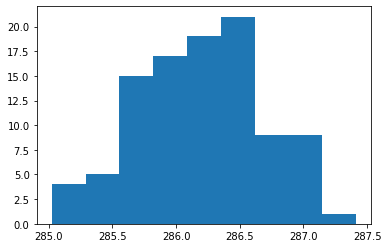

In [27]:

_=plt.hist(preds_p.t_850.isel(lat=20,lon=30,time=2), bins='auto')
plt.show()

# Getting Observations

In [28]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't')

observation=xr.Dataset()
observation['z_500']=z500_valid
observation['t_850']=t850_valid

observation=observation.astype('float64')
observation=observation.drop('level')

In [29]:
observation

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [30]:
observation.z_500.values[0,0,0],observation.t_850.values[0,0,0]

(50954.625, 257.8413391113281)

In [31]:
obs=observation.sel(time=preds_p.time)

In [36]:
obs.t_850.isel(lat=20,lon=30,time=2).values

array(286.24569702)

In [73]:
#RMSE with 20 forecats, 3 months
ensemblemean=preds_d.mean('member')
mean_rmse_d=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse_d)

ensemblemean=preds_p.mean('member')
mean_rmse_p=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse_p)

<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 326.4
    t_850_rmse  float64 1.852
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 330.0
    t_850_rmse  float64 1.865


In [74]:
#MAE
ensemblemean=preds_d.mean('member')
mae_d=compute_weighted_mae(ensemblemean,observation).load(); print(mae_d)

ensemblemean=preds_p.mean('member')
mae_p=compute_weighted_mae(ensemblemean,observation).load(); print(mae_p)

<xarray.Dataset>
Dimensions:    ()
Data variables:
    z_500_mae  float64 207.6
    t_850_mae  float64 1.285
<xarray.Dataset>
Dimensions:    ()
Data variables:
    z_500_mae  float64 213.7
    t_850_mae  float64 1.304


In [18]:
#RMSE 100 forecasts, full year. Still deterministic better.
#RMSE
ensemblemean=preds_d.mean('member')
mean_rmse_d=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse_d)

ensemblemean=preds_p.mean('member')
mean_rmse_p=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse_p)

<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 315.5
    t_850_rmse  float64 1.826
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 317.9
    t_850_rmse  float64 1.837


# Comparing among dropout rates

In [19]:
exp_id='80-resnet_d3_dr_0.05'
preds_1=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

exp_id='81-resnet_d3_dr_0.1'
preds_2=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

exp_id='82-resnet_d3_dr_0.2'
preds_3=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [20]:
preds_1.z_500.values[0,0,0,0],preds_2.z_500.values[0,0,0,0] #checking

(51144.479085007035, 50877.623626030865)

In [25]:
preds=preds_1
mean_spread=compute_weighted_meanspread(preds); print(mean_spread)
ensemblemean=preds.mean('member'), print(preds.member[-1].values)
mean_rmse=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse)

spread_skill_ratio_z500=mean_spread.z_500_mean_spread/mean_rmse.z_500_rmse
spread_skill_ratio_t850=mean_spread.t_850_mean_spread/mean_rmse.t_850_rmse
print(spread_skill_ratio_z500), print(spread_skill_ratio_t850)

<xarray.Dataset>
Dimensions:            ()
Data variables:
    z_500_mean_spread  float64 115.8
    t_850_mean_spread  float64 0.5757
99


ValueError: operands could not be broadcast together with shapes (17520, 32, 64) (2,)

In [78]:
#Spread Skill for dropout 0.05.  
#turns better with increased ensemble_members. (.3 for n=5 --> .34 for n=20,)
preds=preds_1
mean_spread=compute_weighted_meanspread(preds); print(mean_spread)
ensemblemean=preds.mean('member'), print(preds.member[-1].values)
mean_rmse=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse)

spread_skill_ratio_z500=mean_spread.z_500_mean_spread/mean_rmse.z_500_rmse
spread_skill_ratio_t850=mean_spread.t_850_mean_spread/mean_rmse.t_850_rmse
print(spread_skill_ratio_z500), print(spread_skill_ratio_t850)

<xarray.Dataset>
Dimensions:            ()
Data variables:
    z_500_mean_spread  float64 116.2
    t_850_mean_spread  float64 0.5807
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 323.8
    t_850_rmse  float64 1.838
<xarray.DataArray ()>
array(0.35877172)
<xarray.DataArray ()>
array(0.31599459)


(None, None)

In [82]:
preds=preds_2
mean_spread=compute_weighted_meanspread(preds); print(mean_spread)
ensemblemean=preds.mean('member')
mean_rmse=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse)

spread_skill_ratio_z500=mean_spread.z_500_mean_spread/mean_rmse.z_500_rmse
spread_skill_ratio_t850=mean_spread.t_850_mean_spread/mean_rmse.t_850_rmse
print(spread_skill_ratio_z500), print(spread_skill_ratio_t850)

<xarray.Dataset>
Dimensions:            ()
Data variables:
    z_500_mean_spread  float64 129.5
    t_850_mean_spread  float64 0.6338
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 330.0
    t_850_rmse  float64 1.865
<xarray.DataArray ()>
array(0.39244767)
<xarray.DataArray ()>
array(0.33992577)


(None, None)

In [83]:
preds=preds_3
mean_spread=compute_weighted_meanspread(preds); print(mean_spread)
ensemblemean=preds.mean('member')
mean_rmse=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse)

spread_skill_ratio_z500=mean_spread.z_500_mean_spread/mean_rmse.z_500_rmse
spread_skill_ratio_t850=mean_spread.t_850_mean_spread/mean_rmse.t_850_rmse
print(spread_skill_ratio_z500), print(spread_skill_ratio_t850)

<xarray.Dataset>
Dimensions:            ()
Data variables:
    z_500_mean_spread  float64 147.1
    t_850_mean_spread  float64 0.7061
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 338.0
    t_850_rmse  float64 1.924
<xarray.DataArray ()>
array(0.43518015)
<xarray.DataArray ()>
array(0.36707694)


(None, None)

In [110]:
#rmse dr_0.05<deterministic<dr_0.1<dr_0.2
#spread-skill ratio dr_0.2>dr_0.1>dr_0.05

In [23]:
#Spread-Skill Grid
preds=preds_2 #dropout=0.1
#Spread
var1=preds.var('member') 
mean_spread=np.sqrt(var1.mean('time'));print(mean_spread)

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (lat, lon) float64 145.2 145.2 146.2 146.4 ... 219.0 220.2 221.3
    t_850    (lat, lon) float64 0.7542 0.7579 0.7701 ... 0.9945 1.001 1.006


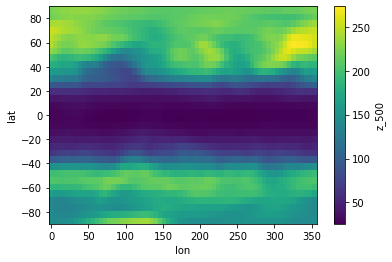

In [85]:
mean_spread.z_500.plot() #mean spread is much more at high/low latitudes, 
#which is okay since there size is smaller and they will contribute less because of weightedness?

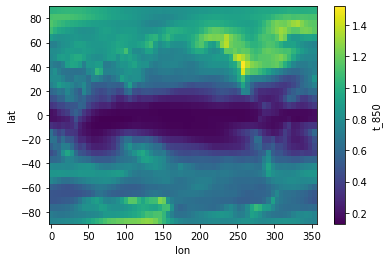

In [86]:
mean_spread.t_850.plot() #why are temperatures always worse. is it because at 2m there is more error-prone observations

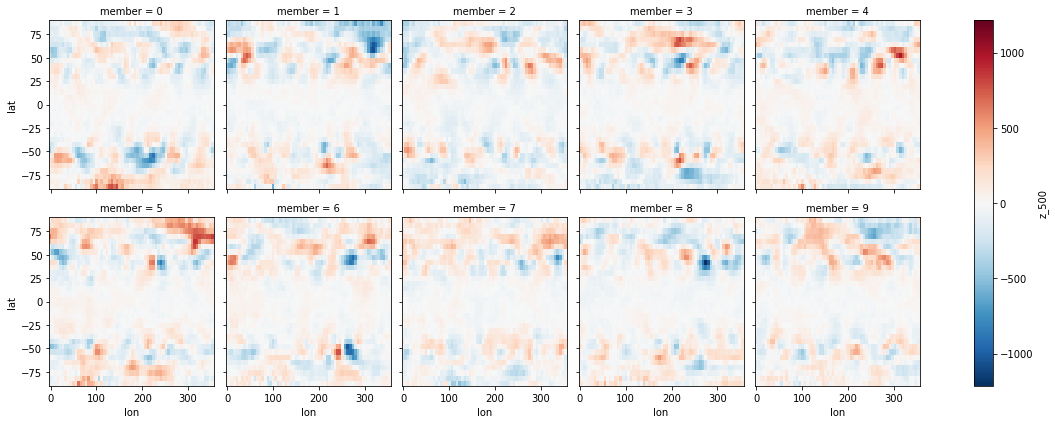

In [87]:
(preds.z_500.isel(time=0) - preds.z_500.isel(time=0).mean('member'))[:10].plot(col='member', col_wrap=5)

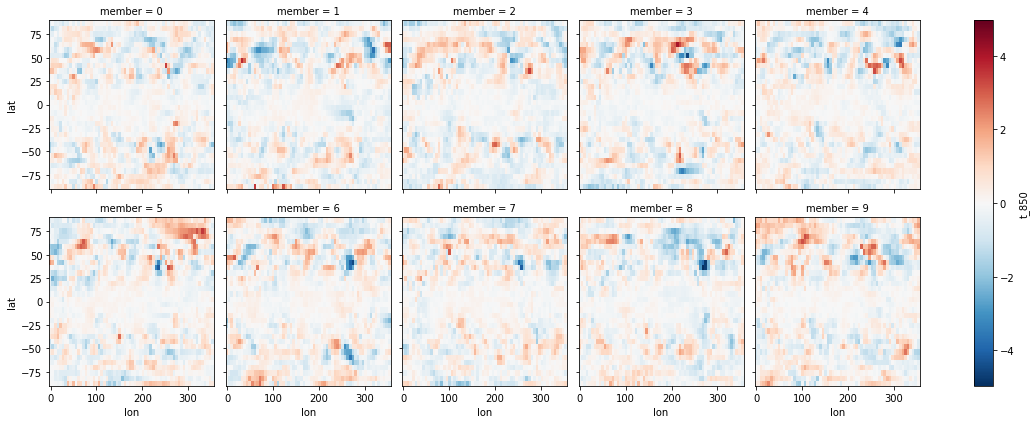

In [88]:
(preds.t_850.isel(time=0) - preds.t_850.isel(time=0).mean('member'))[:10].plot(col='member', col_wrap=5)

In [34]:
#CRPS. Working now. doesnt work sometimes! Need space. or load in batches.
#preds=preds_1.sel(member=slice(0,9))
preds=preds_1
from src.score import * #ToDo: Solve. Need to re-load everytime.
member_axis=xr.DataArray.get_axis_num(preds.z_500,'member')
crps_score=crps_score(preds, obs,member_axis); print(crps_score)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 167.6
    t850     float64 1.065


In [35]:
preds=preds_2
from src.score import * #ToDo: Solve. Need to re-load everytime.
member_axis=xr.DataArray.get_axis_num(preds.z_500,'member')
crps_score=crps_score(preds, obs,member_axis); print(crps_score)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 171.8
    t850     float64 1.076


In [36]:
preds=preds_3
from src.score import * #ToDo: Solve. Need to re-load everytime.
member_axis=xr.DataArray.get_axis_num(preds.z_500,'member')
crps_score=crps_score(preds, obs,member_axis); print(crps_score)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 169.4
    t850     float64 1.1


In [30]:
#for determinstic, this should be same as mae
mae_d=compute_weighted_mae(preds_d,observation).load(); print(mae_d)

<xarray.Dataset>
Dimensions:    ()
Data variables:
    z_500_mae  float64 207.6
    t_850_mae  float64 1.285


In [32]:
ensemblemean=preds_1.mean('member')
mae_p=compute_weighted_mae(ensemblemean,observation).load(); print(mae_p)

ensemblemean=preds_2.mean('member')
mae_p=compute_weighted_mae(ensemblemean,observation).load(); print(mae_p)

ensemblemean=preds_3.mean('member')
mae_p=compute_weighted_mae(ensemblemean,observation).load(); print(mae_p)

<xarray.Dataset>
Dimensions:    ()
Data variables:
    z_500_mae  float64 205.7
    t_850_mae  float64 1.275
<xarray.Dataset>
Dimensions:    ()
Data variables:
    z_500_mae  float64 213.7
    t_850_mae  float64 1.304
<xarray.Dataset>
Dimensions:    ()
Data variables:
    z_500_mae  float64 215.0
    t_850_mae  float64 1.349


#So mae is similar trend as rmse
#And crps is better for probabilistic always, which should be. 
#But deterministic has better weighted rmse than dr_0.1, dr_0.2 . How?

#rmse,mae dr_0.05<deterministic<dr_0.1<dr_0.2
#spread-skill ratio dr_0.2>dr_0.1>dr_0.05
#crps dr_0.05 < dr_0.2< dr_0.1 < deterministic.

#overall the dr_0.05 is better at rmse, crps, but worse at spread-skill ratio.
#CRPS improves with inreasing ensemble size.

# Rank Histogram

In [37]:
#Method 3: Rank Histogram
from ranky import rankz

obs = np.asarray(obs.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.

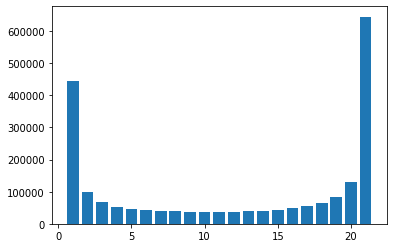

In [38]:
pred=np.asarray(preds_1.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

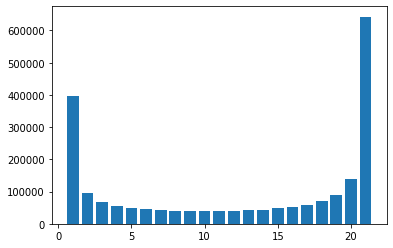

In [39]:
pred=np.asarray(preds_2.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

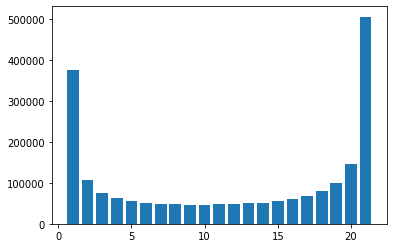

In [40]:
pred=np.asarray(preds_3.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

#Rank histograms dont really tell much here. So I stick with 
#crps scores to compare among dropout rates
#rmse to compare among determinstic and probabilistic

In [49]:
#Ensemble size
assert (preds==preds_3).all
obs=observation.sel(time=preds.time)

In [50]:
from src.score import * #ToDo: Solve. Need to re-load everytime.
member_axis=xr.DataArray.get_axis_num(preds.z_500,'member')
crps_score=crps_score(preds, obs,member_axis); print(crps_score)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 169.4
    t850     float64 1.1


In [51]:
from src.score import * #ToDo: Solve. Need to re-load everytime.
preds=preds.sel(member=slice(0,9))
crps_score=crps_score(preds, obs,member_axis); print(crps_score)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 172.8
    t850     float64 1.118


In [52]:
from src.score import * #ToDo: Solve. Need to re-load everytime.
preds=preds.sel(member=slice(0,5))
crps_score=crps_score(preds, obs,member_axis); print(crps_score)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 177.3
    t850     float64 1.141
